In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import csv
import json
import os.path
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ELU
from keras.optimizers import Adam
from keras.regularizers import l2
import tensorflow as tf
%matplotlib inline

In [8]:
def import_data(csv_file, side_image = True):
    data = pd.read_csv(csv_file, header = None)
    data.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
    # Center Data
    center_data = data[['center', 'steering']]
    center_data.columns = ['image', 'steering']
    # If we use the side images
    if side_image is True:
        # Left Data
        left_data = data[['left', 'steering']]
        left_data.columns = ['image', 'steering']
        left_data = left_data[(left_data.steering > 0.0)]
        # Right Data
        right_data = data[['right', 'steering']]
        right_data.columns = ['image', 'steering']
        right_data = right_data[(right_data.steering < 0.0)]
        # Frame
        frames = [left_data, center_data, right_data]
        # Concat data
        data = pd.concat(frames, axis = 0, ignore_index = True)
    else:
        data = center_data
    # Trainning data
    X_train = data.iloc[:,0].values
    y_train = data.iloc[:,1].values.astype(np.float32)
    return X_train, y_train

X_train, y_train = import_data('driving_log.csv')


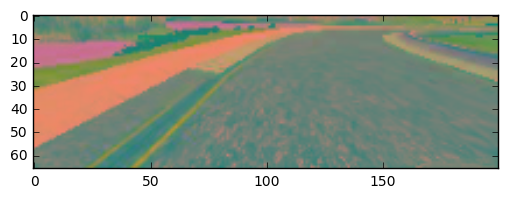

(66, 200, 3)


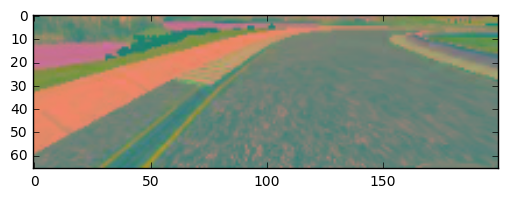

(66, 200, 3)


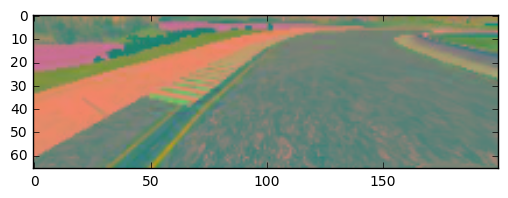

(66, 200, 3)


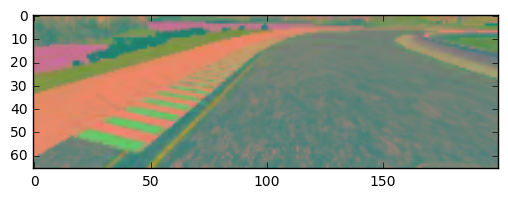

(66, 200, 3)


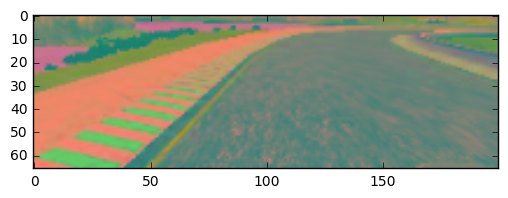

(66, 200, 3)


In [18]:
def load_image(path):
    width, height = 200, 66
    path.replace(' ','')
    image = cv2.imread(path)
    image = image[60:image.shape[0] - 20, :]
    image = cv2.resize(image, (width, height))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    return image

for i in range(5):
    image = load_image(X_train[i][1:])
    plt.imshow(image)
    plt.show()
    print(image.shape)


In [130]:
from sklearn.model_selection import train_test_split

def image_generator(x, y):
    while True:
        for i in range(len(x)):
            path = x[i]
            if path.startswith(' '):
                path = path[1:]
            feature = load_image(path)
            label = np.array([[y[i]]])
            feature = feature.reshape(1, 66, 200, 3)
            yield feature, label

def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
              input_shape=(66, 200, 3),
              output_shape=(66, 200, 3)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse", metrics = ['accuracy'])
    model.summary()
    return model

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

train_size = y_train.shape[0]
val_size = y_val.shape[0]
model = get_model()

model.fit_generator(image_generator(X_train, y_train),
                    samples_per_epoch = train_size,
                    nb_epoch = 5,
                    validation_data = image_generator(X_val, y_val),
                    nb_val_samples = val_size)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_22 (Lambda)               (None, 66, 200, 3)    0           lambda_input_22[0][0]            
____________________________________________________________________________________________________
convolution2d_62 (Convolution2D) (None, 17, 50, 16)    3088        lambda_22[0][0]                  
____________________________________________________________________________________________________
elu_81 (ELU)                     (None, 17, 50, 16)    0           convolution2d_62[0][0]           
____________________________________________________________________________________________________
convolution2d_63 (Convolution2D) (None, 9, 25, 32)     12832       elu_81[0][0]                     
___________________________________________________________________________________________

In [ ]:
json_string = model.to_json()
with open(fileModelJSON,'w' ) as f:
    json.dump(json_string, f)
if Path(fileWeights).is_file():
    os.remove(fileWeights)
model.save_weights(fileWeights)